<h1 style="font-size:40px"><center>Deep Learning</center></h1>
<h2 style="font-size:25px"><center>Assignment # 5</center></h2>

### Library Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<h3 style="font-size:30px"><center>Task 1</center></h3>

### Loading Data

In [2]:
# Data directory
data_dir = '/mnt/4A34DB4C34DB39A1/Miscellaneous/Data Science Datasets/Corona Dataset/Assignment 5 Dataset'


# Defining transformations
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# Applying transformations on the data
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)


# Data Loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)


print("**** Classes ****")
class_names = tuple(train_data.classes)
print(class_names)

**** Classes ****
('infected', 'normal')


### Displaying a batch of training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


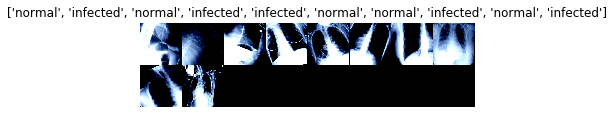

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

### Loading pre-trained VGG-16 & ResNet18

In [4]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

### Freezing the layers

In [5]:
for param in vgg16.features.parameters():
    param.require_grad = False
    
for param in resnet18.parameters():
    param.require_grad = False

### Removing last layer + Extending VGG-16 & ResNet18

In [6]:
roll_num = 65
out_features = (roll_num * 10) + 100

# Removing last layer of VGG-16
num_features = vgg16.classifier[0].in_features
classifier = list(vgg16.classifier.children())

# Extending VGG-16
classifier[0] = nn.Linear(num_features, out_features)
classifier.insert(1, nn.ReLU(inplace=True))
classifier.insert(2, nn.Dropout(p=0.5, inplace=False))
classifier.insert(3, nn.Linear(out_features, out_features))
classifier[6] = nn.Linear(out_features, out_features)
classifier.insert(7, nn.ReLU(inplace=True))
classifier.insert(8, nn.Dropout(p=0.5, inplace=False))
classifier.insert(9, nn.Linear(out_features, out_features))
classifier[12] = nn.Linear(out_features, out_features)
classifier.extend([nn.ReLU(inplace=True)])
classifier.extend([nn.Dropout(p=0.5, inplace=False)])
classifier.extend([nn.Linear(out_features, len(class_names))])
vgg16.classifier = nn.Sequential(*classifier)


# Extending ResNet-18
resnet18.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(512, out_features)), ('relu', nn.ReLU()), ('fc2', nn.Linear(out_features, 2)), ('output', nn.LogSoftmax(dim=1))]))

print('Last layers removed.')

Last layers removed.


### Printing updated Architectures

##### (1) VGG-16

In [7]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

###### (2) ResNet-18

In [8]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss Function & Optimizer

In [9]:
Epochs = 3
criterion = nn.CrossEntropyLoss()
vgg16_optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

### Training

##### (1) VGG-16

In [10]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()


vgg16_cross_entropy = []
vgg16_valid_accuracy = []

# Running Epochs
for epoch in range(Epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        vgg16_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        vgg16_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    vgg16_cross_entropy.append(loss.data)
        
    torch.save(vgg16.state_dict(), 'Saved Models/vgg16_FC_Only.pth')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    vgg16_valid_accuracy.append((100 * correct / total))
        

print('VGG-16 Trained!')

Train Epoch: 0 [11990/12000 (100%)]	Loss: 0.315445: : 1200it [25:32,  1.28s/it]
Train Epoch: 1 [11990/12000 (100%)]	Loss: 0.069298: : 1200it [25:35,  1.28s/it]
Train Epoch: 2 [11990/12000 (100%)]	Loss: 0.840951: : 1200it [24:43,  1.24s/it]


VGG-16 Trained!


##### (2) ResNet-18

In [13]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()


resnet18_cross_entropy = []
resnet18_valid_accuracy = []

# Running Epochs
for epoch in range(Epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        resnet18_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        resnet18_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    resnet18_cross_entropy.append(loss.data)
        
    torch.save(resnet18.state_dict(), 'Saved Models/res18_FC_Only.pth')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    resnet18_valid_accuracy.append((100 * correct / total))
    

print('ResNet-18 Trained!')

Train Epoch: 0 [11990/12000 (100%)]	Loss: 0.078330: : 1200it [10:15,  1.95it/s]
Train Epoch: 1 [11990/12000 (100%)]	Loss: 0.191413: : 1200it [09:32,  2.10it/s]
Train Epoch: 2 [11990/12000 (100%)]	Loss: 0.825636: : 1200it [08:56,  2.24it/s]


ResNet-18 Trained!


### Plottings

##### (1) VGG-16

*** Validation Accuracy ***


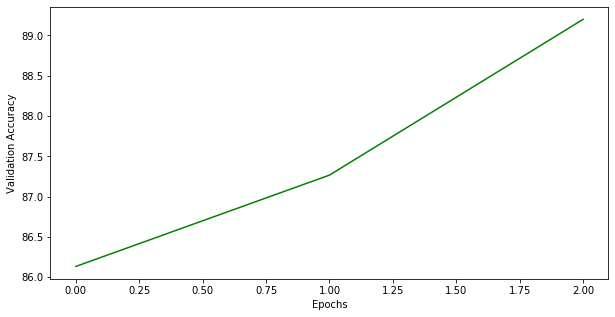

*** Cross Entropy Curve ***


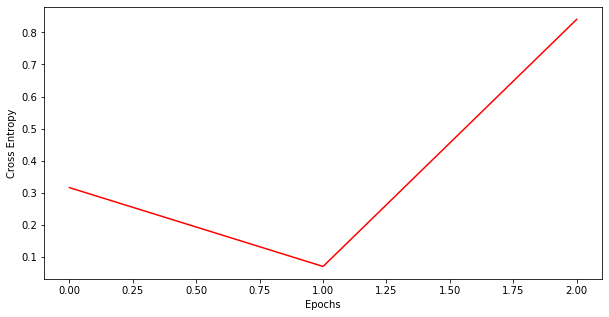

In [11]:
print('*** Validation Accuracy ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_valid_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()    


print('*** Cross Entropy Curve ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_cross_entropy, color='red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.show() 

##### (2) ResNet-18

*** Validation Accuracy ***


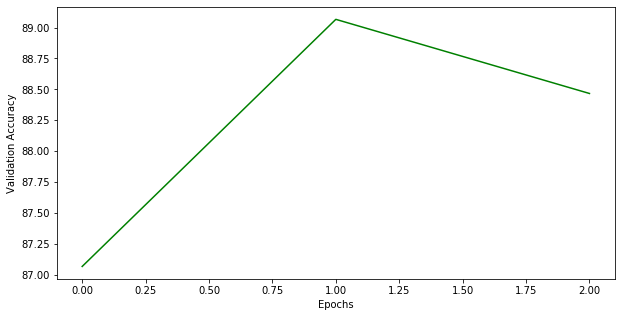

*** Cross Entropy Curve ***


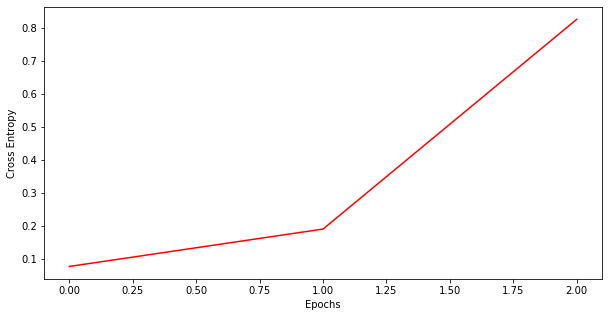

In [14]:
print('*** Validation Accuracy ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_valid_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()    


print('*** Cross Entropy Curve ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_cross_entropy, color='red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.show() 

### Testing

##### (1) VGG-16

In [12]:
# Computing Accuracy, F1 Score & Confusion Matrix

correct = 0
total = 0

precision = 0
recall = 0
f_score = 0

infected_true = 0
infected_false = 0
normal_true = 0
normal_false = 0


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            if labels[i].item() == 0:
                if predicted[i].item() == 0: normal_true += 1 
                else: normal_false +=1
            else:
                if predicted[i].item() == 1: infected_true += 1 
                else: infected_false +=1
                    

# Accuracy
print('VGG-16 Test Accuracy: %d %%' % (100 * correct / total))   


# F1 Score
precision = normal_true/(normal_true+normal_false)
recall = normal_true/(normal_true+infected_false)
f_score = 2*(precision*recall)/(precision+recall)
print('VGG-16 Test F1 Score: %d %%' % (100 * f_score))                 
                    
    
actual_labels = ["Actual Normal", "Actual Infected"]
predicted_labels = ["Predicted Normal", "Predicted Infected"]
confusion_matrix = np.array([[normal_true, infected_false], [normal_false, infected_true]])
pd.DataFrame(confusion_matrix, actual_labels, predicted_labels)

VGG-16 Test Accuracy: 95 %
VGG-16 Test F1 Score: 94 %


,Predicted Normal,Predicted Infected
Actual Normal,592,40
Actual Infected,23,845


##### (2) ResNet-18

In [15]:
# Computing Accuracy, F1 Score & Confusion Matrix

correct = 0
total = 0

precision = 0
recall = 0
f_score = 0

infected_true = 0
infected_false = 0
normal_true = 0
normal_false = 0


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            if labels[i].item() == 0:
                if predicted[i].item() == 0: normal_true += 1 
                else: normal_false +=1
            else:
                if predicted[i].item() == 1: infected_true += 1 
                else: infected_false +=1
                    

# Accuracy
print('ResNet-18 Test Accuracy: %d %%' % (100 * correct / total))   


# F1 Score
precision = normal_true/(normal_true+normal_false)
recall = normal_true/(normal_true+infected_false)
f_score = 2*(precision*recall)/(precision+recall)
print('ResNet-18 Test F1 Score: %d %%' % (100 * f_score))                 
                    
    
actual_labels = ["Actual Normal", "Actual Infected"]
predicted_labels = ["Predicted Normal", "Predicted Infected"]
confusion_matrix = np.array([[normal_true, infected_false], [normal_false, infected_true]])
pd.DataFrame(confusion_matrix, actual_labels, predicted_labels)

ResNet-18 Test Accuracy: 94 %
ResNet-18 Test F1 Score: 93 %


,Predicted Normal,Predicted Infected
Actual Normal,565,27
Actual Infected,50,858


<h3 style="font-size:30px"><center>Task 2</center></h3>

### Loading pre-trained VGG-16 & ResNet18

In [16]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

### Experimentation with Freezing of Layers

In [17]:
# Feezing only even layers

count = 1

for param in vgg16.features.parameters():
    if count%2 == 0:
        param.require_grad = False
    count += 1
    
count = 1
    
for param in resnet18.parameters():
    if count%2 == 0:
        param.require_grad = False
    count +=1

### Removing last layer + Extending VGG-16 & ResNet18

In [18]:
roll_num = 65
out_features = (roll_num * 10) + 100

# Removing last layer of VGG-16
num_features = vgg16.classifier[0].in_features
classifier = list(vgg16.classifier.children())

# Extending VGG-16
classifier[0] = nn.Linear(num_features, out_features)
classifier.insert(1, nn.ReLU(inplace=True))
classifier.insert(2, nn.Dropout(p=0.5, inplace=False))
classifier.insert(3, nn.Linear(out_features, out_features))
classifier[6] = nn.Linear(out_features, out_features)
classifier.insert(7, nn.ReLU(inplace=True))
classifier.insert(8, nn.Dropout(p=0.5, inplace=False))
classifier.insert(9, nn.Linear(out_features, out_features))
classifier[12] = nn.Linear(out_features, out_features)
classifier.extend([nn.ReLU(inplace=True)])
classifier.extend([nn.Dropout(p=0.5, inplace=False)])
classifier.extend([nn.Linear(out_features, len(class_names))])
vgg16.classifier = nn.Sequential(*classifier)


# Extending ResNet-18
resnet18.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(512, out_features)), ('relu', nn.ReLU()), ('fc2', nn.Linear(out_features, 2)), ('output', nn.LogSoftmax(dim=1))]))

print('Last layers removed.')

Last layers removed.


### Loss Function & Optimizer

In [19]:
Epochs = 3
criterion = nn.CrossEntropyLoss()
vgg16_optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

### Training

##### (1) VGG-16

In [20]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()


vgg16_cross_entropy = []
vgg16_valid_accuracy = []

# Running Epochs
for epoch in range(Epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        vgg16_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        vgg16_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    vgg16_cross_entropy.append(loss.data)
        
    torch.save(vgg16.state_dict(), 'Saved Models/vgg16_entire.pth')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    vgg16_valid_accuracy.append((100 * correct / total))
    

print('VGG-16 Trained!')

Train Epoch: 0 [11990/12000 (100%)]	Loss: 0.379502: : 1200it [25:49,  1.29s/it]
Train Epoch: 1 [11990/12000 (100%)]	Loss: 0.486947: : 1200it [26:00,  1.30s/it]
Train Epoch: 2 [11990/12000 (100%)]	Loss: 1.064488: : 1200it [25:04,  1.25s/it]


VGG-16 Trained!


##### (2) ResNet-18

In [21]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()


resnet18_cross_entropy = []
resnet18_valid_accuracy = []

# Running Epochs
for epoch in range(Epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        resnet18_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        resnet18_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    resnet18_cross_entropy.append(loss.data)
        
    torch.save(resnet18.state_dict(), 'Saved Models/res18_entire.pth')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    resnet18_valid_accuracy.append((100 * correct / total))
    

print('ResNet-18 Trained!')

Train Epoch: 0 [11990/12000 (100%)]	Loss: 0.276316: : 1200it [09:05,  2.20it/s]
Train Epoch: 1 [11990/12000 (100%)]	Loss: 0.113863: : 1200it [09:15,  2.16it/s]
Train Epoch: 2 [11990/12000 (100%)]	Loss: 0.210666: : 1200it [09:16,  2.16it/s]


ResNet-18 Trained!


### Plotting

##### (1) VGG-16

*** Validation Accuracy ***


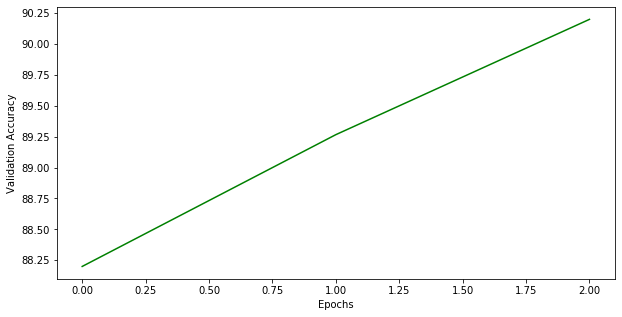

*** Cross Entropy Curve ***


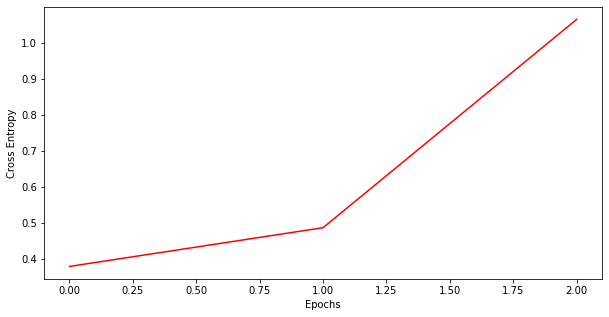

In [22]:
print('*** Validation Accuracy ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_valid_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()    


print('*** Cross Entropy Curve ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_cross_entropy, color='red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.show() 

##### (2) ResNet-18

*** Validation Accuracy ***


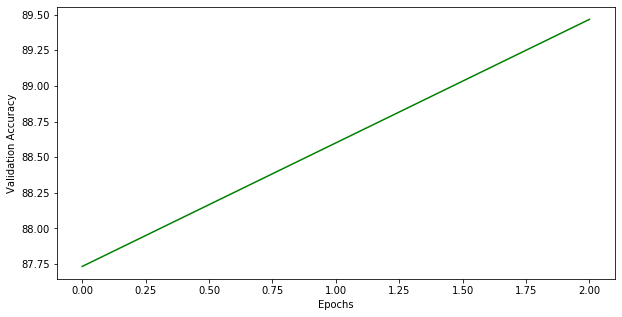

*** Cross Entropy Curve ***


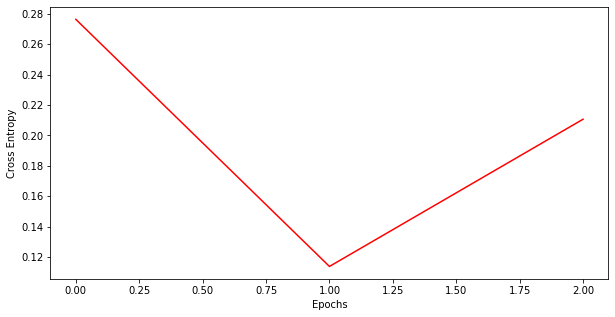

In [23]:
print('*** Validation Accuracy ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_valid_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()    


print('*** Cross Entropy Curve ***')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_cross_entropy, color='red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.show() 

### Testing

##### (1) VGG-16

In [24]:
# Computing Accuracy, F1 Score & Confusion Matrix

correct = 0
total = 0

precision = 0
recall = 0
f_score = 0

infected_true = 0
infected_false = 0
normal_true = 0
normal_false = 0


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            if labels[i].item() == 0:
                if predicted[i].item() == 0: normal_true += 1 
                else: normal_false +=1
            else:
                if predicted[i].item() == 1: infected_true += 1 
                else: infected_false +=1
                    

# Accuracy
print('VGG-16 Test Accuracy: %d %%' % (100 * correct / total))   


# F1 Score
precision = normal_true/(normal_true+normal_false)
recall = normal_true/(normal_true+infected_false)
f_score = 2*(precision*recall)/(precision+recall)
print('VGG-16 Test F1 Score: %d %%' % (100 * f_score))                 
                    
    
actual_labels = ["Actual Normal", "Actual Infected"]
predicted_labels = ["Predicted Normal", "Predicted Infected"]
confusion_matrix = np.array([[normal_true, infected_false], [normal_false, infected_true]])
pd.DataFrame(confusion_matrix, actual_labels, predicted_labels)

VGG-16 Test Accuracy: 96 %
VGG-16 Test F1 Score: 95 %


,Predicted Normal,Predicted Infected
Actual Normal,582,19
Actual Infected,33,866


##### (2) ResNet-18

In [25]:
# Computing Accuracy, F1 Score & Confusion Matrix

correct = 0
total = 0

precision = 0
recall = 0
f_score = 0

infected_true = 0
infected_false = 0
normal_true = 0
normal_false = 0


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            if labels[i].item() == 0:
                if predicted[i].item() == 0: normal_true += 1 
                else: normal_false +=1
            else:
                if predicted[i].item() == 1: infected_true += 1 
                else: infected_false +=1
                    

# Accuracy
print('ResNet-18 Test Accuracy: %d %%' % (100 * correct / total))   


# F1 Score
precision = normal_true/(normal_true+normal_false)
recall = normal_true/(normal_true+infected_false)
f_score = 2*(precision*recall)/(precision+recall)
print('ResNet-18 Test F1 Score: %d %%' % (100 * f_score))                 
                    
    
actual_labels = ["Actual Normal", "Actual Infected"]
predicted_labels = ["Predicted Normal", "Predicted Infected"]
confusion_matrix = np.array([[normal_true, infected_false], [normal_false, infected_true]])
pd.DataFrame(confusion_matrix, actual_labels, predicted_labels)

ResNet-18 Test Accuracy: 94 %
ResNet-18 Test F1 Score: 92 %


,Predicted Normal,Predicted Infected
Actual Normal,546,18
Actual Infected,69,867
